In [1]:
# ipython settings
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import mean_squared_error # we are going to assess the quality of the model based on the generalization MSE
from sklearn.metrics import accuracy_score
from sympy import init_printing # We use sympy to display mathematical expresssions 
import numpy as np # we use numpy to deal with arrays
import lime 
import lime.lime_tabular
init_printing()

In [3]:
def f(X):
    X = np.array(X)
    Y = np.zeros((X.shape[0], 2))
    radius = 0.4**2
    margin = 0.01
    center = (0.5, 0.5)
        
    Y[(X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2 <= radius - margin, 0] = 1.
    Y[(X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2 <= radius - margin, 1] = 0.
    
    Y[(radius - margin < (X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2) *\
          ((X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2 <= radius), 0] = .75
    Y[(radius - margin < (X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2) *\
          ((X[:, 0] - center[0]) **2 + (X[:, 1] - center[1]) **2 <= radius), 1] = .25
    

    Y[(radius < (X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2) *\
          ((X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2 <= radius + margin), 0] = .25
    Y[(radius < (X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2) *\
          ((X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2 <= radius + margin), 1] = .75
    
    Y[(X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2 > (radius + margin), 0] = 0.
    Y[(X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2 > (radius + margin), 1] = 1.
    
    return Y

dim_X = 2

In [4]:
n_pts = 100
X = np.random.uniform(0, 1, (n_pts, dim_X))

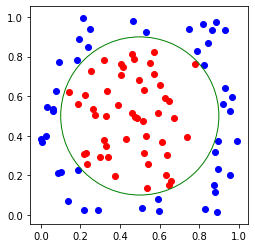

In [5]:
import matplotlib.pyplot as plt
y = f(X)
figure, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0.5, 0.5), 0.4, color='g', fill=False)
ax.add_artist(circle)
ax.scatter(X[:, 0][y[:, 0] > 0.75], X[:, 1][y[:, 0] > 0.75], c='r')
ax.scatter(X[:, 0][y[:, 1] > 0.75], X[:, 1][y[:, 1] > 0.75], c='b')

plt.savefig("syndata.png")
plt.show()


In [6]:
n_test = 50
X_test = np.random.uniform(0, 1, (n_test, dim_X))

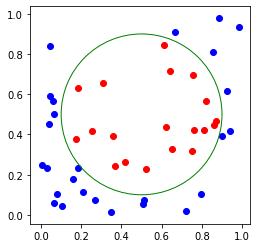

In [7]:
import matplotlib.pyplot as plt
y_ = f(X_test)
figure, ax = plt.subplots()
ax.set_aspect(1)
circle = plt.Circle((0.5, 0.5), 0.4, color='g', fill=False)
ax.add_artist(circle)
ax.scatter(X_test[:, 0][y_[:, 0] > 0.75], X_test[:, 1][y_[:, 0] > 0.75], c='r')
ax.scatter(X_test[:, 0][y_[:, 1] > 0.75], X_test[:, 1][y_[:, 1] > 0.75], c='b')
plt.show()

In [ ]:
from symbolic_pursuit.classification import SymbolicClassifier  # our symbolic model class

symbolic_model = SymbolicClassifier(maxiter=20,
                                    nclasses=2,
                                    eps=1.0e-5)
symbolic_model.fit(f, X)

Model created with the following hyperparameters :
 loss_tol=0.001 
 ratio_tol=0.9 
 maxiter=20 
 eps=1e-05 
 random_seed=42
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Now working on term number  1 .
Now working on hyperparameter tree number  1 .


In [9]:
print (accuracy_score(np.argmax(symbolic_model.predict(X_test), 1), np.argmax(f(X_test), 1)))


0.56


In [21]:
symbolic_weight_list = [] 
for k in range(n_test):
    symbolic_weight_list.append(symbolic_model.get_feature_importance(X_test[k]))

In [22]:
print (symbolic_weight_list)

[[0.202450201235661, 0.326152908930971], [-0.0834801291273856, -0.135274571873370], [-0.0646685842030177, -0.104792982876342], [-0.0779079213229854, -0.126245555448475], [0.0174180637840733, 0.0282174357865640], [-0.0277392680399458, -0.0449539722182689], [-0.0828929316179947, -0.134323096956594], [0.0381082071439821, 0.0613884220088209], [-0.0702264987484397, -0.113145074313903], [-0.00924543394668309, -0.0149871910699629], [0.784820417476618, 1.26438511399818], [0.160604735845195, 0.260232259936687], [-0.0735765058915387, -0.119227076876536], [0.0104795382798203, 0.0168770335679514], [0.143047856044636, 0.230452284550689], [-0.0808873337039917, -0.131073294159763], [-0.0349574679688055, -0.0566500984223889], [-0.0823779072078709, -0.133488568880567], [0.0419576283407539, 0.0675900628842625], [0.0187398940716817, 0.0301849459802017], [-0.0444986965797252, -0.0721103814674037], [-0.0375410930566080, -0.0608365168354132], [0.0173174981712846, 0.0280544826804485], [-0.0790741132139657, -

In [23]:
relative_wts = np.array(symbolic_weight_list)[np.argmax(f(X_test), 1) == 0]
relative_wts /= relative_wts[:, 0][..., None]
print (np.mean(relative_wts[:, 1]), np.var(relative_wts[:, 1]))

1.61683400653396 2.39992012789675e-5


In [24]:
Y = np.argmax(f(X_test), 1)
for i in range(5):
    print (symbolic_model.predict([X_test[i]]))
    poly1 = symbolic_model.get_taylor(X_test[i], approx_order=2)
    print(poly1, Y[i])

[[0.49994047 0.50005953]]
0.202440201235661*X0 + 0.326142908930971*X1 - 0.923887511749522*(0.620710111095833*X0 + X1 - 0.231089005808058)**2 + 0.270367611245486 1
[[0.5000182 0.4999818]]
-0.0834901291273856*X0 - 0.13528457187337*X1 - 0.0742361329467596*(0.451505818962808*X0 + 0.73160470650995*X1 - 1)**2 + 0.516643335857985 1
[[0.50004113 0.49995887]]
-0.0646785842030177*X0 - 0.104802982876342*X1 - 0.0810614209452742*(0.571188618345317*X0 + 0.925534653011353*X1 - 1)**2 + 0.479747432458203 1
[[0.50000903 0.49999097]]
-0.0779179213229854*X0 - 0.126255555448475*X1 - 0.0776112165119551*(0.488139837242659*X0 + 0.790965226499434*X1 - 1)**2 + 0.504780506670452 0
[[0.50000632 0.49999368]]
0.0174080637840733*X0 + 0.028207435786564*X1 - 0.227555144982471*(0.617144497493289*X0 + X1 - 0.561358213610699)**2 + 0.377248440290949 1


In [ ]:
def order_weights(exp_list):
    ordered_weights = [0 for _ in range(dim_X)]
    for tup in exp_list:
        feature_id = int(tup[0].split('x_')[1][0])
        ordered_weights[feature_id-1] = tup[1]    
    return ordered_weights   

In [ ]:
lime_weight_list = []
explainer = lime.lime_tabular.LimeTabularExplainer(X, 
                                                   feature_names=["x_"+str(k) for k in range(1,dim_X+1)], 
                                                   class_names=['f'], 
                                                   verbose=False,
                                                   mode='classification')

for i in range(n_test):
    exp = explainer.explain_instance(X_test[i], f, num_features=dim_X)
    lime_weight_list.append(order_weights(exp.as_list()))  
                            
print(lime_weight_list) 

In [ ]:
relative_wts = np.array(lime_weight_list)
relative_wts /= relative_wts[:, 0][..., None]
print (np.mean(relative_wts[:, 1]), np.var(relative_wts[:, 1]))